# Determinental Point Process (DPP)

This notebook demonstrates how to draw random samples from FiniteDPP process defined by a square exponential similarity kernel with different values of lenght_scale and prefactor. 

For each combination of lenght_scale and prefactor, we draw a random sample and compute the average and the standard deviation in the number of objects.

In [ ]:
#!pip install -U neptune-notebooks

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy
from genus.util_ml import Grid_DPP, compute_logp_bernoulli, compute_entropy_bernoulli
from genus.util_vis import show_batch

In [37]:
class simplified_model(torch.nn.Module):
    def __init__(self,
                 length_scale: float,
                 weight: float):
        super().__init__()
        B, W, H = 8, 10, 10
        self.n_mc_samples = 100
        self.grid_dpp = Grid_DPP(length_scale=length_scale,
                                 weight=weight,
                                 learnable_params=False)
        
        self.logit = torch.nn.Parameter(data=torch.randn((B,1,W,H), dtype=torch.float), requires_grad=True)
    
    def forward(self, generate_synthetic_data=False, method=2):
        prob = torch.sigmoid(self.logit)

        if generate_synthetic_data:
            # sample from dpp prior
            c_grid_before_nms_mcsamples = self.grid_dpp.sample(size=prob.size()).unsqueeze(dim=0)
        else:
            prob_expanded = prob.expand([self.n_mc_samples] + list(prob.shape))
            c_grid_before_nms_mcsamples = (torch.rand_like(prob_expanded) < prob_expanded)
        
        if method == 1:
            logp_ber_before_nms_mb = compute_logp_bernoulli(c=c_grid_before_nms_mcsamples.detach(),
                                                            logit=self.logit).sum(dim=(-1, -2, -3))
            logp_dpp_before_nms_mb = self.grid_dpp.log_prob(value=c_grid_before_nms_mcsamples.squeeze(-3).detach())
            f = logp_ber_before_nms_mb - logp_dpp_before_nms_mb
            baseline = f.mean(dim=-2).detach()
            delta = (f-baseline)
            logit_kl_av = torch.mean(logp_ber_before_nms_mb * delta.detach() + delta)
        else:
            entropy_b = compute_entropy_bernoulli(logit=self.logit).sum(dim=(-1, -2, -3))
            logp_ber_before_nms_mb = compute_logp_bernoulli(c=c_grid_before_nms_mcsamples.detach(),
                                                            logit=self.logit).sum(dim=(-1, -2, -3))
            logp_dpp_before_nms_mb = self.grid_dpp.log_prob(value=c_grid_before_nms_mcsamples.squeeze(-3).detach())
            baseline = logp_dpp_before_nms_mb.mean(dim=-2).detach()
            delta = (logp_dpp_before_nms_mb - baseline)
            logit_kl_av = (-entropy_b - logp_ber_before_nms_mb * delta.detach()).mean()
        loss = logit_kl_av
        return loss, c_grid_before_nms_mcsamples, delta.mean()

In [38]:
import neptune.new as neptune

exp = neptune.init(project='dalessioluca/genus-new')
                                    
model = simplified_model(length_scale=5.0, weight=0.2)
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': 0.001}])

https://ui.neptune.ai/dalessioluca/genus-new/e/GEN1-70


In [39]:
loss, c_grid = model.forward(generate_synthetic_data=True)

ValueError: too many values to unpack (expected 2)

In [ ]:
show_batch(c_grid[0].float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="c_grid_prior", title="PRIOR")

In [40]:
for epoch in range(1000):
    loss, c_grid, delta = model.forward()
    
    optimizer.zero_grad()
    loss.backward()  # do back_prop and compute all the gradients
    optimizer.step()  # update the parameters    
    
    if epoch % 100 == 0:
        n_cell = c_grid.sum(dim=(-1,-2,-3)).float().mean().detach().item()
        exp["n_cell"].log(n_cell)
        logit_min = torch.min(model.logit).item()
        logit_mean = torch.mean(model.logit).item()
        logit_max = torch.max(model.logit).item()
        exp["logit/min"].log(logit_min)
        exp["logit/mean"].log(logit_mean)
        exp["logit/max"].log(logit_max)
        exp["delta"].log(delta.detach().item())
        
        show_batch(c_grid[0].float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="c_grid", 
                   title="epoch="+str(epoch))
        show_batch(model.logit, pad_value=1.0, n_padding=2, normalize_range=(-3.0, 3.0), 
               normalize=True, experiment=exp, neptune_name="logit/raw", title="epoch="+str(epoch))
        
        print(epoch, loss)

0 tensor(-69.0482, grad_fn=<MeanBackward0>)
100 tensor(-68.9649, grad_fn=<MeanBackward0>)
200 tensor(-81.2637, grad_fn=<MeanBackward0>)
300 tensor(-91.8169, grad_fn=<MeanBackward0>)
400 tensor(-83.3469, grad_fn=<MeanBackward0>)
500 tensor(-108.2815, grad_fn=<MeanBackward0>)
600 tensor(-116.2634, grad_fn=<MeanBackward0>)
700 tensor(-122.3692, grad_fn=<MeanBackward0>)
800 tensor(-121.8282, grad_fn=<MeanBackward0>)
900 tensor(-128.8625, grad_fn=<MeanBackward0>)


https://ui.neptune.ai/dalessioluca/genus-new/e/GEN1-80


TypeError: path must be a str or NoneType (was <class 'matplotlib.figure.Figure'>)

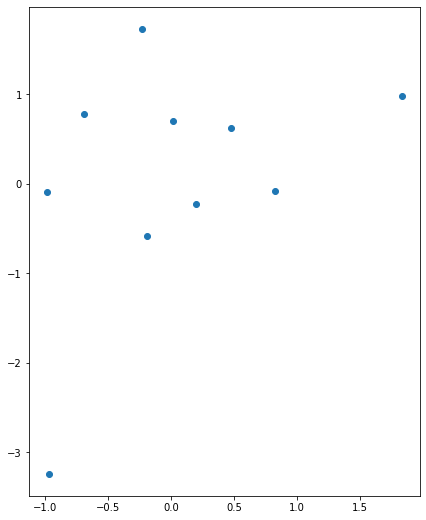

In [43]:
import neptune.new as neptune
from neptune.new.types import File
import torch
exp = neptune.init("dalessioluca/genus-new")
for i in range(10):
    fig = plt.figure(figsize=(7, 9))
    plt.scatter(torch.randn(10),torch.randn(10))
    #exp['matplolib-series-v1'].log(fig)
    exp['matplolib-series-v1'].log(File(fig))

    fig.savefig("tmp1.png")
    exp['matplolib-series-v2'].log(File("tmp1.png"))

    if i == 0:
        exp['matplolib-single'].upload(fig)

In [ ]:
model.

In [36]:
exp.stop()

In [ ]:
c_grid[0].shape

In [ ]:
show_batch(c_grid[0].float(), pad_value=0.5, n_padding=2, experiment=exp, neptune_name="c_grid")